# qPCR analysis

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
from scipy import stats

from statsmodels.stats import multitest
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd


Notebook for graphing qPCR data for the manuscript.

MOI 0.1 (particle normalized). 13h then sort.

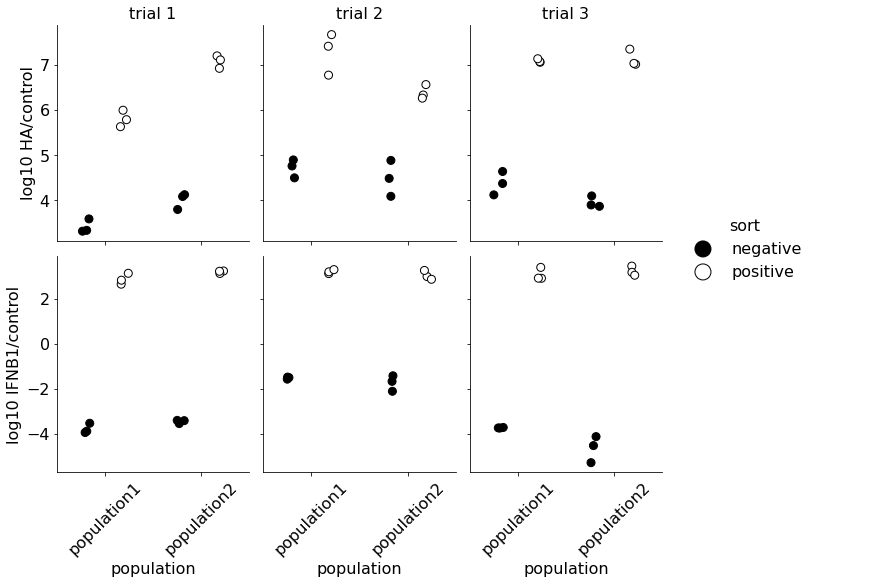

In [2]:
directory = 'Data/qPCR/qPCR_sort.csv'
data = pd.read_csv(directory).dropna(how='all')
data['value'] = (data.control - data.value)

columnName = 'trial'
rows = len(set(data.target))
columns = len(set(data[columnName])) 
xVal = 'population'
hue = 'sort'
sampleFont = 16
width = 3
height = 4
hue_order = ['negative', 'positive']
controlName = 'control'
rotate = True
if hue != '':
    columns += 1
#initialize figure
g= plt.figure(1,(width*columns,rows*height), constrained_layout=True)
spec = g.add_gridspec(rows,columns)
row = 0
col = 0
firstPlot = ''
cornerPlot = ''
for target in (sorted(set(data.target))):
    for element in (sorted(set(data[columnName]))):
        if (col == 0):
            ax = g.add_subplot(spec[row, col])
            firstPlot = ax
            if row == 0:
                cornerPlot = ax
        else:
            ax = g.add_subplot(spec[row, col], sharey=firstPlot, sharex=cornerPlot)
        if hue != '':
            sns.stripplot(x=xVal, y='value', data=data[(data[columnName] == element) & (data.target == target)].groupby(
                ['population','replicate', hue]).mean().reset_index(), hue = hue, hue_order=hue_order,
                jitter=True, dodge=True, linewidth=1, palette=['0','1'], edgecolor='black', ax = ax, s=8)
        else:
            sns.stripplot(x=xVal, y='value', data=data[(data[columnName] == element) & (data.target == target)].groupby(
                ['population','replicate', hue]).mean().reset_index(),
                jitter=True, dodge=True, linewidth=1, palette=['0'], edgecolor='black', ax = ax)
        ax.tick_params(labelsize=sampleFont)
        sns.despine()
        ax.get_legend().remove()
        if row == 0:
            ax.set_title(' '.join([str(columnName), str(element)]), fontsize=sampleFont)
        if col != 0:
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.yaxis.label.set_visible(False)
        else:
            ax.set_ylabel('log10 ' + target + '/' + controlName, fontsize=sampleFont)
        if row != (rows -1):
            plt.setp(ax.get_xticklabels(), visible=False)
            ax.xaxis.label.set_visible(False)  
        else:
            ax.set_xlabel(xVal, fontsize=sampleFont)

        if hue != '':
            col = (col+1) % (columns - 1)
        else:
            col = (col+1) % (columns - 1)
        if col == 0:
            row += 1
        if rotate:
            plt.xticks(rotation=45)

if hue != '': 
    axObj = ax.collections[0:2]
    ax = g.add_subplot(spec[:,-1])
    ax.axis('off')
    legend = ax.legend(axObj,hue_order, loc='center left', bbox_to_anchor=(0, 0.5), title=hue,
        fontsize = sampleFont, markerscale=2)
    legend.get_title().set_fontsize(sampleFont) 
    legend.get_frame().set_linewidth(0.0)
    for lh in legend.legendHandles: 
        lh.set_alpha(1)  

plt.savefig('Figures/sortingqpcr.pdf')

Impact of ribavirin on interferon expression

(1e-05, 0.1)

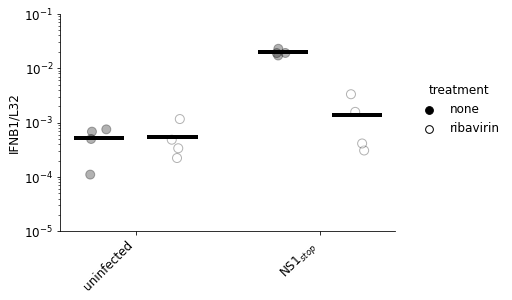

In [21]:
directory = 'Data/qPCR/ribavirin.csv'
graph = pd.read_csv(directory).dropna(how='all')


order = ['uninfected','NS1-stop']
nameOrder = ['uninfected','NS1$_{stop}$']
ax=sns.stripplot(x='virus', y='IFNB1', data=graph,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue="ribavirin", hue_order=['No','Yes'],palette=['0','1'], alpha = 0.3)

sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('')
ax.legend(handles[0:2], ['none','ribavirin'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='treatment')

plt.ylabel('IFNB1/L32')
a =plt.xticks(np.arange(0,2,1),nameOrder,rotation=45, ha='right')
ax.set_yscale('log')

for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')


for position, strain in enumerate(order):
    curr = graph[graph['virus'] == strain]
    y = curr[curr.ribavirin == 'No'].IFNB1.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=9)
    y = curr[curr.ribavirin == 'Yes'].IFNB1.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=9)
    
plt.savefig('Figures/IFNribavirinqPCR.pdf', format='pdf', bbox_inches = "tight")
plt.ylim(0.00001,0.1)

In [5]:
graph['category'] = graph.virus + '_' + graph.ribavirin


stat, pval = scipy.stats.f_oneway(*[graph[graph.category == category].IFNB1 for category in set(graph.category)])
if pval < 0.05:
    tukey = pairwise_tukeyhsd(endog=graph['IFNB1'],
                              groups=graph['category'],
                              alpha=0.05)
    print(tukey)
else:
    print('No significant difference detected by ANOVA at a pvalue of 0.05')

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2     meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
  NS1-stop_No   NS1-stop_Yes  -0.0181  0.001  -0.021 -0.0151   True
  NS1-stop_No  uninfected_No   -0.019  0.001 -0.0219  -0.016   True
  NS1-stop_No uninfected_Yes  -0.0189  0.001 -0.0219  -0.016   True
 NS1-stop_Yes  uninfected_No  -0.0009 0.7872 -0.0038   0.002  False
 NS1-stop_Yes uninfected_Yes  -0.0009 0.8093 -0.0038  0.0021  False
uninfected_No uninfected_Yes      0.0    0.9 -0.0029   0.003  False
-------------------------------------------------------------------


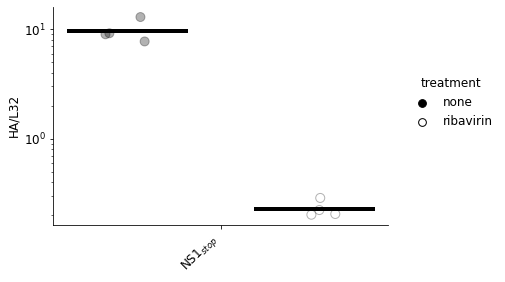

In [30]:
order = ['NS1-stop']
nameOrder = ['NS1$_{stop}$']
ax=sns.stripplot(x='virus', y='HA', data=graph,  edgecolor='black', order = order,
            jitter=True, dodge=True, linewidth=1, s=9, hue="ribavirin", hue_order=['No','Yes'],palette=['0','1'], alpha = 0.3)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('')
ax.legend(handles[0:2], ['none','ribavirin'], bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.,frameon=False, title='treatment')

plt.ylabel('HA/L32')
a =plt.xticks(np.arange(0,1,1),nameOrder,rotation=45, ha='right')
ax.set_yscale('log')
for legend_handle in ax.get_legend().legendHandles:  
       legend_handle.set_edgecolor('black')
curr = graph[graph.virus == 'NS1-stop']
tstat, pval = stats.ttest_ind(curr[curr.ribavirin == 'No'].HA, curr[curr.ribavirin == 'Yes'].HA )

for position, strain in enumerate(order):
    curr = graph[graph['virus'] == strain]
    y = curr[curr.ribavirin == 'No'].HA.mean()
    plt.plot([position-0.325, position-0.075], [y, y], lw=4, c='k', zorder=9)
    y = curr[curr.ribavirin == 'Yes'].HA.mean()
    plt.plot([position+0.075, position+0.325], [y, y], lw=4, c='k', zorder=9)
plt.savefig('Figures/HAribavirinqPCR.pdf', format='pdf', bbox_inches = "tight")


calculations of particle to infectivity ratios

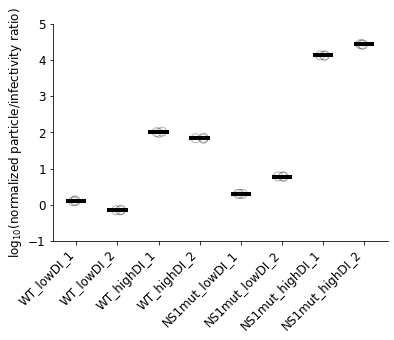

In [11]:
data = pd.read_csv('Data/ViralTiters/particle_infectivity.csv')
data = data.rename(columns={'Cq mean': 'Cq_mean', 'Cq stdv': 'Cq_stdv'})
data['dCq'] = data.at[0,'Cq'] - data.Cq
data['genomes_normalized'] = 2 ** data.dCq
data['ratio'] = data.genomes_normalized / data.TCID50
standard = data.loc[data['Sample'].isin(['WT_lowDI_1', 'WT_lowDI_2']),'ratio'].mean()
data['ratio_normalized'] = data['ratio'] / standard
data['ratio_normalized_log'] = np.log10(data.ratio_normalized)
graph = data
order = graph['Sample'].drop_duplicates().tolist()
#nameOrder = ['WT ', 'MOI 5']

ax=sns.stripplot(x='Sample', y='ratio_normalized_log', data=graph,  edgecolor='black', palette=['1'], order = order,
            jitter=True, dodge=True, linewidth=1, s=9, alpha = 0.3)


sns.despine()
plt.ylim(-1,5)
plt.xlabel('')

plt.ylabel('log$_{10}$(normalized particle/infectivity ratio)') #normalized to average of low-defective WT (all bio and tech replicates)
#plt.yticks(np.arange(-2,3,1))
plt.xticks(np.arange(0,8,1), order, rotation=45, ha='right')

#plt.axhline(y=-1, color = 'k',ls = '--', alpha =0.5)
#for legend_handle in ax.get_legend().legendHandles:  
#       legend_handle.set_edgecolor('black')

pvals = []
for position, virus in enumerate(order):
    curr = graph[graph['Sample'] == virus]
    y = curr.ratio_normalized_log.mean()
    plt.plot([position-0.2, position+0.2], [y, y], lw=4, c='k', zorder=9)
    
plt.savefig('Figures/particle_infectivity.pdf', format='pdf', bbox_inches = "tight")